In [1]:
import numpy as np 
import matplotlib
import nnfs
from nnfs.datasets import spiral_data

In [2]:
nnfs.init()

In [3]:
class DenseLayer:
    def __init__(self, n_inputs, n_neurons) -> None:
        self.weights = np.random.randn(n_inputs, n_neurons) #Arranged this way order to avoid having to transpose.
        self.biases = np.zeros([1, n_neurons])
    
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues) #Inputs first parameter to insure the dim of the output.
        self.dinputs = np.dot(dvalues, self.weights.T) #Same here.
        self.dbaises = np.sum(dvalues, axis=0, keepdims=True) #D of baises is always 1, simpler to use sum to perform chainrule.

class ActReLU:
    def forward(self, inputs):
       self.output = np.maximum(0, inputs) 

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Loss:
    def calculate_data_loss(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss
    
class Loss_categoticalCrossentropy(Loss):
    def forward(self, predictions, y_true):
        n_inputs = len(predictions)
        pclipped = np.clip(predictions, 1e-7, 1-1e-7) #Avoids errors harboured by 0.

        if len(y_true.shape) == 1:
            correct_p = pclipped[range(n_inputs), y_true]
        elif len(y_true.shape) == 2: #Deals with one hot encoding.
            correct_p = np.sum(pclipped*y_true, axis=1)

        nlogp = -np.log(correct_p)
        return nlogp
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[1])
        
        if len(y_true.shape)==1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true/dvalues
        self.dinputs =  self.dinputs / samples



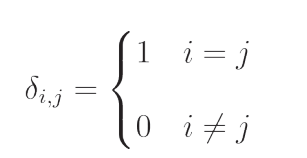

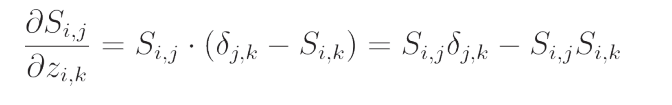

In [12]:
class SoftMax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True)) #Subtract the max for numerical stability.
        p = exp_values/np.sum(exp_values, axis=1, keepdims=True)
        self.output = p

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        for i, (s_out, s_dvalue) in enumerate(zip(self.output, dvalues)):
            s_out_f = s_out.reshape(-1, 1)
            o_kron_delta = np.eye(s_out.shape[0]) * s_out
            jacobian_matrix = o_kron_delta - np.dot(s_out_f, s_out_f) #Transposing seems useless, since it is one d.
            self.dinputs[i] = np.dot(jacobian_matrix, s_dvalue)

In [5]:
X, y = spiral_data(samples=200, classes=6)

layer1= DenseLayer(2, 12)
layer2 = DenseLayer(12, 6)
activation1 = ActReLU()
activation2 = SoftMax()
loss_func = Loss_categoticalCrossentropy()

In [6]:
layer1.forward(X)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)
loss = loss_func.calculate_data_loss(activation2.output, y)

In [7]:
print('loss:', loss)
print(activation2.output[:5])

loss: 2.9486704
[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1667776  0.16400273 0.16693424 0.16734108 0.16667613 0.16826817]
 [0.16785693 0.16202044 0.1684566  0.16510753 0.16791017 0.16864832]
 [0.1715918  0.15899445 0.16614863 0.16362962 0.17484806 0.1647874 ]
 [0.1725753  0.15694186 0.16703677 0.16207029 0.1759652  0.16541064]]


In [8]:
predictions = np.argmax(activation2.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions==y)
accuracy

0.14833333333333334